In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from inceptionresnet import inceptionresnetv2

In [2]:
from object_detection_utils.object_detection_helper import *
from object_detection_utils.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_utils.RetinaNet import RetinaNet
from object_detection_utils.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [3]:
import fastai.utils.collect_env
fastai.utils.collect_env.check_perf()

Running performance checks.

*** libjpeg-turbo status
✘ libjpeg-turbo is not on. It's recommended you install libjpeg-turbo to speed up JPEG decoding. See https://docs.fast.ai/performance.html#libjpeg-turbo

*** Pillow-SIMD status
✘ Running Pillow 5.4.1; It's recommended you install Pillow-SIMD to speed up image resizing and other operations. See https://docs.fast.ai/performance.html#pillow-simd

*** CUDA status
❓ Running cpu-only torch version, CUDA check is not relevant

Refer to https://docs.fast.ai/performance.html to make sense out of these checks and suggestions.


In [4]:
torch.cuda.empty_cache()

In [5]:
# could improve performance (not tested with fastai)
torch.backends.cudnn.enabled = True 

### Check dataset 

In [6]:
path = Path('data/ILSVRC/Data/CLS-LOC')

In [7]:
os.listdir(path)

['export',
 'imagenet_199px_object_detection.pkl',
 'imagenet_256px_object_detection.pkl',
 'imagenet_299px_object_detection.pkl',
 'models',
 'test',
 'train',
 'valid']

In [8]:
len(os.listdir(path/'train'))

1000

In [9]:
os.listdir(path/'train')[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [10]:
len(os.listdir(path/'valid'))

50000

In [11]:
os.listdir(path/'valid')[:5]

['ILSVRC2012_val_00000001.JPEG',
 'ILSVRC2012_val_00000002.JPEG',
 'ILSVRC2012_val_00000003.JPEG',
 'ILSVRC2012_val_00000004.JPEG',
 'ILSVRC2012_val_00000005.JPEG']

In [12]:
len(os.listdir(path/'test'))

100000

In [13]:
os.listdir(path/'test')[:5]

['ILSVRC2012_test_00000001.JPEG',
 'ILSVRC2012_test_00000002.JPEG',
 'ILSVRC2012_test_00000003.JPEG',
 'ILSVRC2012_test_00000004.JPEG',
 'ILSVRC2012_test_00000005.JPEG']

In [14]:
annotation_path = Path('data/ILSVRC/Annotations/CLS-LOC')

In [15]:
os.listdir(annotation_path)[:5]

['train', 'valid']

In [16]:
len(os.listdir(annotation_path/'train'))

1000

In [17]:
os.listdir(annotation_path/'train')[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [18]:
os.listdir(annotation_path/'train/n01440764')[:5]

['n01440764_10040.xml',
 'n01440764_10048.xml',
 'n01440764_10074.xml',
 'n01440764_1009.xml',
 'n01440764_10108.xml']

In [19]:
len(os.listdir(annotation_path/'valid'))

50000

In [20]:
os.listdir(annotation_path/'valid')[:5]

['ILSVRC2012_val_00000001.xml',
 'ILSVRC2012_val_00000002.xml',
 'ILSVRC2012_val_00000003.xml',
 'ILSVRC2012_val_00000004.xml',
 'ILSVRC2012_val_00000005.xml']

In [21]:
os.listdir(annotation_path/'valid')[0]

'ILSVRC2012_val_00000001.xml'

### extract annotations

In [22]:
#path

In [23]:
#import xml.etree.ElementTree as ET

In [24]:
#fnames = []
#lbl_bboxes = []

In [25]:
#for annotation in os.listdir('data/ILSVRC/Annotations/CLS-LOC/valid/'):
#    bboxes = []
#    root = ET.parse('data/ILSVRC/Annotations/CLS-LOC/valid/'+annotation).getroot()
#    
#    bbox_tag = root.findall('object/bndbox')
#    xmin = [r.find('xmin').text for r in bbox_tag]
#    ymin = [r.find('ymin').text for r in bbox_tag]
#    xmax = [r.find('xmax').text for r in bbox_tag]
#    ymax = [r.find('ymax').text for r in bbox_tag]
#    
#    for i in range(0, len(bbox_tag)):
#        bboxes.append([int(ymin[i]), int(xmin[i]), int(ymax[i]), int(xmax[i])])
#    
#    obj_tag = root.findall('object')
#    category = [r.find('name').text for r in obj_tag]
#    
#    fname_tag = root.findall('filename')
#    fname = fname_tag[0].text + '.JPEG' 
#    fnames += ['valid' + '/' + fname]
#    
#    lbl_bboxes.append([bboxes, category])

In [26]:
#for folder in os.listdir('data/ILSVRC/Annotations/CLS-LOC/train/'):
#    for annotation in os.listdir('data/ILSVRC/Annotations/CLS-LOC/train/' + folder):
#        bboxes = []
#        root = ET.parse('data/ILSVRC/Annotations/CLS-LOC/train/' + folder + '/' + annotation).getroot()
#
#        bbox_tag = root.findall('object/bndbox')
#        xmin = [r.find('xmin').text for r in bbox_tag]
#        ymin = [r.find('ymin').text for r in bbox_tag]
#        xmax = [r.find('xmax').text for r in bbox_tag]
#        ymax = [r.find('ymax').text for r in bbox_tag]
#
#        for i in range(0, len(bbox_tag)):
#            bboxes.append([int(ymin[i]), int(xmin[i]), int(ymax[i]), int(xmax[i])])
#
#        obj_tag = root.findall('object')
#        category = [r.find('name').text for r in obj_tag]
#
#        fname_tag = root.findall('filename')
#        fname = fname_tag[0].text + '.JPEG' 
#        fnames += ['train/' + folder + '/' + fname]
#        
#        lbl_bboxes.append([bboxes, category])

In [27]:
#fname2bbox = dict(zip(fnames, lbl_bboxes))

In [28]:
#dict(list(fname2bbox.items())[0:4])

In [29]:
#len(fname2bbox)

### define metric 

In [30]:
def top_5_accuracy(input, targs, k=5):
    return top_k_accuracy(input, targs, k)

### for the full ILSV2017 classification dataset

In [31]:
#def path2fn(path):
#    if 'val' in path:
#        return re.search('\w*\/\w*\.JPEG$', path).group(0)
#    else:
#        return re.search('\w*\/\w*\/\w*\.JPEG$', path).group(0)

In [32]:
#get_y_func = lambda o: fname2bbox[path2fn(o)]

In [33]:
#SZ = 199

In [34]:
#list(fname2bbox.keys())[0]

In [35]:
#data_bunch = (ObjectItemList.from_df(pd.DataFrame(data=list(fname2bbox.keys())), path=path)
#                            .split_by_rand_pct(valid_pct=0.2, seed=21)
#                            .label_from_func(get_y_func)
#                            .transform(get_transforms(), tfm_y=True, size=SZ)
#                            .databunch(bs=64, num_workers=8, collate_fn=bb_pad_collate))
#                            #.normalize(imagenet_stats))

In [36]:
#data_bunch.save('imagenet_199px_object_detection.pkl')

In [37]:
#SZ = 256

In [38]:
#data_bunch = (ObjectItemList.from_df(pd.DataFrame(data=list(fname2bbox.keys())), path=path)
#                           .split_by_rand_pct(valid_pct=0.2, seed=21)
#                           .label_from_func(get_y_func)
#                           .transform(get_transforms(), tfm_y=True, size=SZ)
#                           .databunch(bs=16, collate_fn=bb_pad_collate)
#                           .normalize(imagenet_stats))

In [39]:
#data_bunch.save('imagenet_256px_object_detection.pkl')

In [40]:
#SZ = 299

In [41]:
#data_bunch = (ObjectItemList.from_df(pd.DataFrame(data=list(fname2bbox.keys())), path=path)
#                            .split_by_rand_pct(valid_pct=0.2, seed=21)
#                            .label_from_func(get_y_func)
#                            .transform(get_transforms(), tfm_y=True, size=SZ)
#                            .databunch(bs=16, collate_fn=bb_pad_collate)
#                            .normalize(imagenet_stats))

In [43]:
#data_bunch.save('imagenet_299px_object_detection.pkl')

### if the databunch has been saved

In [44]:
size = 256

In [45]:
data_bunch = load_data('data/ILSVRC/Data/CLS-LOC', 'imagenet_256px_object_detection.pkl', 
                       collate_fn=bb_pad_collate, bs=8, num_workers=8)

NotImplementedError: cannot instantiate 'PosixPath' on your system

### quick look at the images

In [46]:
data_bunch.show_batch(rows=2, figsize=(6,6))

NameError: name 'data_bunch' is not defined

In [47]:
data_bunch.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

NameError: name 'data_bunch' is not defined

In [47]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [48]:
#fig,ax = plt.subplots(figsize=(15,15))
#ax.imshow(image2np(data_bunch.valid_ds[0][0].data))
#
#for i, bbox in enumerate(anchors[:18]):
#    bb = bbox.numpy()
#    x = (bb[0] + 1) * 199 / 2 
#    y = (bb[1] + 1) * 199 / 2 
#    w = bb[2] * 199 / 2
#    h = bb[3] * 199 / 2
#    
#    rect = [x,y,w,h]
#    draw_rect(ax,rect)

In [49]:
#all_boxes, all_labels = show_anchors_on_images(data_bunch, anchors, figsize=(25,25))

### create learner with inceptionresnetv2 (the pytorch model is already pretrained on imagenet)

In [50]:
#def inception(pretrained=False):
#    pretrained = 'imagenet' if pretrained else None
#    model = inceptionresnetv2(pretrained=pretrained)
#    return nn.Sequential(*model.children())

In [51]:
n_classes = data_bunch.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2) 
#encoder = create_body(inception, True, -2)
model = RetinaNet(encoder, n_classes=data_bunch.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)

In [52]:
voc = PascalVOCMetric(anchors, size, [i for i in data_bunch.train_ds.y.classes[1:]])
learn = Learner(data_bunch, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics], metrics=[voc])

In [53]:
#learn = cnn_learner(data_bunch, inception, pretrained=True, cut=-2, split_on=lambda m: (m[0][9], m[1]))

In [54]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [55]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [56]:
learn.freeze()

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


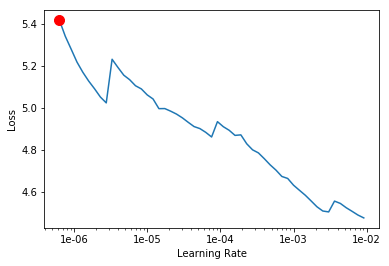

In [58]:
learn.recorder.plot(suggestion=True)

In [59]:
lr = 1e-3

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-n01440764,AP-n01443537,AP-n01484850,AP-n01491361,AP-n01494475,AP-n01496331,AP-n01498041,AP-n01514668,AP-n01514859,AP-n01518878,AP-n01530575,AP-n01531178,AP-n01532829,AP-n01534433,AP-n01537544,AP-n01558993,AP-n01560419,AP-n01580077,AP-n01582220,AP-n01592084,AP-n01601694,AP-n01608432,AP-n01614925,AP-n01616318,AP-n01622779,AP-n01629819,AP-n01630670,AP-n01631663,AP-n01632458,AP-n01632777,AP-n01641577,AP-n01644373,AP-n01644900,AP-n01664065,AP-n01665541,AP-n01667114,AP-n01667778,AP-n01669191,AP-n01675722,AP-n01677366,AP-n01682714,AP-n01685808,AP-n01687978,AP-n01688243,AP-n01689811,AP-n01692333,AP-n01693334,AP-n01694178,AP-n01695060,AP-n01697457,AP-n01698640,AP-n01704323,AP-n01728572,AP-n01728920,AP-n01729322,AP-n01729977,AP-n01734418,AP-n01735189,AP-n01737021,AP-n01739381,AP-n01740131,AP-n01742172,AP-n01744401,AP-n01748264,AP-n01749939,AP-n01751748,AP-n01753488,AP-n01755581,AP-n01756291,AP-n01768244,AP-n01770081,AP-n01770393,AP-n01773157,AP-n01773549,AP-n01773797,AP-n01774384,AP-n01774750,AP-n01775062,AP-n01776313,AP-n01784675,AP-n01795545,AP-n01796340,AP-n01797886,AP-n01798484,AP-n01806143,AP-n01806567,AP-n01807496,AP-n01817953,AP-n01818515,AP-n01819313,AP-n01820546,AP-n01824575,AP-n01828970,AP-n01829413,AP-n01833805,AP-n01843065,AP-n01843383,AP-n01847000,AP-n01855032,AP-n01855672,AP-n01860187,AP-n01871265,AP-n01872401,AP-n01873310,AP-n01877812,AP-n01882714,AP-n01883070,AP-n01910747,AP-n01914609,AP-n01917289,AP-n01924916,AP-n01930112,AP-n01943899,AP-n01944390,AP-n01945685,AP-n01950731,AP-n01955084,AP-n01968897,AP-n01978287,AP-n01978455,AP-n01980166,AP-n01981276,AP-n01983481,AP-n01984695,AP-n01985128,AP-n01986214,AP-n01990800,AP-n02002556,AP-n02002724,AP-n02006656,AP-n02007558,AP-n02009229,AP-n02009912,AP-n02011460,AP-n02012849,AP-n02013706,AP-n02017213,AP-n02018207,AP-n02018795,AP-n02025239,AP-n02027492,AP-n02028035,AP-n02033041,AP-n02037110,AP-n02051845,AP-n02056570,AP-n02058221,AP-n02066245,AP-n02071294,AP-n02074367,AP-n02077923,AP-n02085620,AP-n02085782,AP-n02085936,AP-n02086079,AP-n02086240,AP-n02086646,AP-n02086910,AP-n02087046,AP-n02087394,AP-n02088094,AP-n02088238,AP-n02088364,AP-n02088466,AP-n02088632,AP-n02089078,AP-n02089867,AP-n02089973,AP-n02090379,AP-n02090622,AP-n02090721,AP-n02091032,AP-n02091134,AP-n02091244,AP-n02091467,AP-n02091635,AP-n02091831,AP-n02092002,AP-n02092339,AP-n02093256,AP-n02093428,AP-n02093647,AP-n02093754,AP-n02093859,AP-n02093991,AP-n02094114,AP-n02094258,AP-n02094433,AP-n02095314,AP-n02095570,AP-n02095889,AP-n02096051,AP-n02096177,AP-n02096294,AP-n02096437,AP-n02096585,AP-n02097047,AP-n02097130,AP-n02097209,AP-n02097298,AP-n02097474,AP-n02097658,AP-n02098105,AP-n02098286,AP-n02098413,AP-n02099267,AP-n02099429,AP-n02099601,AP-n02099712,AP-n02099849,AP-n02100236,AP-n02100583,AP-n02100735,AP-n02100877,AP-n02101006,AP-n02101388,AP-n02101556,AP-n02102040,AP-n02102177,AP-n02102318,AP-n02102480,AP-n02102973,AP-n02104029,AP-n02104365,AP-n02105056,AP-n02105162,AP-n02105251,AP-n02105412,AP-n02105505,AP-n02105641,AP-n02105855,AP-n02106030,AP-n02106166,AP-n02106382,AP-n02106550,AP-n02106662,AP-n02107142,AP-n02107312,AP-n02107574,AP-n02107683,AP-n02107908,AP-n02108000,AP-n02108089,AP-n02108422,AP-n02108551,AP-n02108915,AP-n02109047,AP-n02109525,AP-n02109961,AP-n02110063,AP-n02110185,AP-n02110341,AP-n02110627,AP-n02110806,AP-n02110958,AP-n02111129,AP-n02111277,AP-n02111500,AP-n02111889,AP-n02112018,AP-n02112137,AP-n02112350,AP-n02112706,AP-n02113023,AP-n02113186,AP-n02113624,AP-n02113712,AP-n02113799,AP-n02113978,AP-n02114367,AP-n02114548,AP-n02114712,AP-n02114855,AP-n02115641,AP-n02115913,AP-n02116738,AP-n02117135,AP-n02119022,AP-n02119789,AP-n02120079,AP-n02120505,AP-n02123045,AP-n02123159,AP-n02123394,AP-n02123597,AP-n02124075,AP-n02125311,AP-n02127052,AP-n02128385,AP-n02128757,AP-n02128925,AP-n02129165,AP-n02129604,AP-n02130308,AP-n02132136,AP-n02133161,AP-n02134084,AP-n02134418,AP-n02137549,AP-n02138441,AP-n02165105,AP-n02165456,AP-n021671

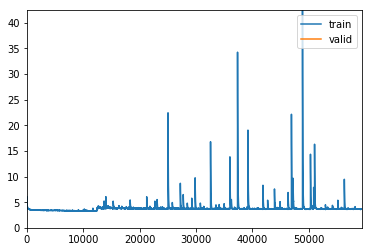

In [60]:
learn.fit_one_cycle(1, max_lr=slice(lr), div_factor=25)

In [61]:
#learn.save('256px_object_detection_frozen');

In [56]:
learn.load('256px_object_detection_frozen');

In [57]:
learn.unfreeze()

In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


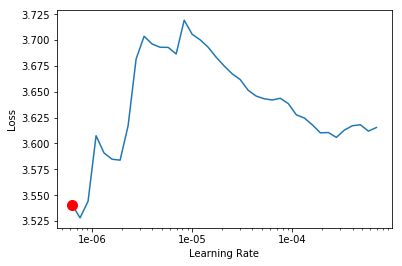

In [59]:
learn.recorder.plot(suggestion=True)

In [60]:
lr = 2e-4

In [61]:
lrs = learn.lr_range(slice(lr/9,lr))
lrs

array([2.222222e-05, 6.666667e-05, 2.000000e-04])

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-n01440764,AP-n01443537,AP-n01484850,AP-n01491361,AP-n01494475,AP-n01496331,AP-n01498041,AP-n01514668,AP-n01514859,AP-n01518878,AP-n01530575,AP-n01531178,AP-n01532829,AP-n01534433,AP-n01537544,AP-n01558993,AP-n01560419,AP-n01580077,AP-n01582220,AP-n01592084,AP-n01601694,AP-n01608432,AP-n01614925,AP-n01616318,AP-n01622779,AP-n01629819,AP-n01630670,AP-n01631663,AP-n01632458,AP-n01632777,AP-n01641577,AP-n01644373,AP-n01644900,AP-n01664065,AP-n01665541,AP-n01667114,AP-n01667778,AP-n01669191,AP-n01675722,AP-n01677366,AP-n01682714,AP-n01685808,AP-n01687978,AP-n01688243,AP-n01689811,AP-n01692333,AP-n01693334,AP-n01694178,AP-n01695060,AP-n01697457,AP-n01698640,AP-n01704323,AP-n01728572,AP-n01728920,AP-n01729322,AP-n01729977,AP-n01734418,AP-n01735189,AP-n01737021,AP-n01739381,AP-n01740131,AP-n01742172,AP-n01744401,AP-n01748264,AP-n01749939,AP-n01751748,AP-n01753488,AP-n01755581,AP-n01756291,AP-n01768244,AP-n01770081,AP-n01770393,AP-n01773157,AP-n01773549,AP-n01773797,AP-n01774384,AP-n01774750,AP-n01775062,AP-n01776313,AP-n01784675,AP-n01795545,AP-n01796340,AP-n01797886,AP-n01798484,AP-n01806143,AP-n01806567,AP-n01807496,AP-n01817953,AP-n01818515,AP-n01819313,AP-n01820546,AP-n01824575,AP-n01828970,AP-n01829413,AP-n01833805,AP-n01843065,AP-n01843383,AP-n01847000,AP-n01855032,AP-n01855672,AP-n01860187,AP-n01871265,AP-n01872401,AP-n01873310,AP-n01877812,AP-n01882714,AP-n01883070,AP-n01910747,AP-n01914609,AP-n01917289,AP-n01924916,AP-n01930112,AP-n01943899,AP-n01944390,AP-n01945685,AP-n01950731,AP-n01955084,AP-n01968897,AP-n01978287,AP-n01978455,AP-n01980166,AP-n01981276,AP-n01983481,AP-n01984695,AP-n01985128,AP-n01986214,AP-n01990800,AP-n02002556,AP-n02002724,AP-n02006656,AP-n02007558,AP-n02009229,AP-n02009912,AP-n02011460,AP-n02012849,AP-n02013706,AP-n02017213,AP-n02018207,AP-n02018795,AP-n02025239,AP-n02027492,AP-n02028035,AP-n02033041,AP-n02037110,AP-n02051845,AP-n02056570,AP-n02058221,AP-n02066245,AP-n02071294,AP-n02074367,AP-n02077923,AP-n02085620,AP-n02085782,AP-n02085936,AP-n02086079,AP-n02086240,AP-n02086646,AP-n02086910,AP-n02087046,AP-n02087394,AP-n02088094,AP-n02088238,AP-n02088364,AP-n02088466,AP-n02088632,AP-n02089078,AP-n02089867,AP-n02089973,AP-n02090379,AP-n02090622,AP-n02090721,AP-n02091032,AP-n02091134,AP-n02091244,AP-n02091467,AP-n02091635,AP-n02091831,AP-n02092002,AP-n02092339,AP-n02093256,AP-n02093428,AP-n02093647,AP-n02093754,AP-n02093859,AP-n02093991,AP-n02094114,AP-n02094258,AP-n02094433,AP-n02095314,AP-n02095570,AP-n02095889,AP-n02096051,AP-n02096177,AP-n02096294,AP-n02096437,AP-n02096585,AP-n02097047,AP-n02097130,AP-n02097209,AP-n02097298,AP-n02097474,AP-n02097658,AP-n02098105,AP-n02098286,AP-n02098413,AP-n02099267,AP-n02099429,AP-n02099601,AP-n02099712,AP-n02099849,AP-n02100236,AP-n02100583,AP-n02100735,AP-n02100877,AP-n02101006,AP-n02101388,AP-n02101556,AP-n02102040,AP-n02102177,AP-n02102318,AP-n02102480,AP-n02102973,AP-n02104029,AP-n02104365,AP-n02105056,AP-n02105162,AP-n02105251,AP-n02105412,AP-n02105505,AP-n02105641,AP-n02105855,AP-n02106030,AP-n02106166,AP-n02106382,AP-n02106550,AP-n02106662,AP-n02107142,AP-n02107312,AP-n02107574,AP-n02107683,AP-n02107908,AP-n02108000,AP-n02108089,AP-n02108422,AP-n02108551,AP-n02108915,AP-n02109047,AP-n02109525,AP-n02109961,AP-n02110063,AP-n02110185,AP-n02110341,AP-n02110627,AP-n02110806,AP-n02110958,AP-n02111129,AP-n02111277,AP-n02111500,AP-n02111889,AP-n02112018,AP-n02112137,AP-n02112350,AP-n02112706,AP-n02113023,AP-n02113186,AP-n02113624,AP-n02113712,AP-n02113799,AP-n02113978,AP-n02114367,AP-n02114548,AP-n02114712,AP-n02114855,AP-n02115641,AP-n02115913,AP-n02116738,AP-n02117135,AP-n02119022,AP-n02119789,AP-n02120079,AP-n02120505,AP-n02123045,AP-n02123159,AP-n02123394,AP-n02123597,AP-n02124075,AP-n02125311,AP-n02127052,AP-n02128385,AP-n02128757,AP-n02128925,AP-n02129165,AP-n02129604,AP-n02130308,AP-n02132136,AP-n02133161,AP-n02134084,AP-n02134418,AP-n02137549,AP-n02138441,AP-n02165105,AP-n02165456,AP-n021671

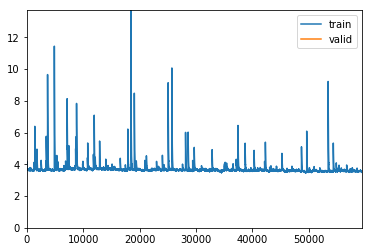

In [62]:
learn.fit_one_cycle(1, max_lr=lrs, div_factor=35)

In [63]:
learn.save('256px_object_detection');

## interpret

In [ ]:
interpr = learn.interpret()

In [ ]:
interpr.plot_top_losses(4, figsize=(12,12))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-5

In [ ]:
lrs = learn.lr_range(slice(lr/9,lr))
lrs

In [ ]:
learn.fit_one_cycle(2, max_lr=lrs, div_factor=35)

In [ ]:
learn.save('299px_inceptionresnetv2_continued')

## prediction 

In [64]:
path

PosixPath('data/ILSVRC/Data/CLS-LOC')

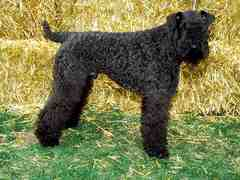

In [65]:
img = open_image(path/'train/n02093859/n02093859_1049.JPEG')
img

In [68]:
prob = learn.predict(img)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
cl, label #, prob

In [ ]:
# Load Imagenet Synsets
with open('data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

# len(synsets)==1001
# sysnets[0] == background
synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

In [ ]:
{k: key_to_classname[k] for k in list(key_to_classname)[:5]}

In [ ]:
key_to_classname[str(cl)]

In [ ]:
learn.export('export/export.pkl')

In [ ]:
learn = load_learner('export')